In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil
from datetime import datetime
from datetime import timedelta
# !pip uninstall pystan -y
# !pip install pystan~=2.14
# !pip install fbprophet
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from numpy import mean
from numpy import std
# !pip install mxnet gluonts ujson
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, date, time
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

2022-02-06 19:05:03.551764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2022-02-06 19:05:03.551833: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#loading data 
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
deep_ds = transactions.drop(['Value'], axis=1)
transaction_values = transactions.drop(['Price'], axis=1)
transaction_values.columns = ['Count']
ethprice = pd.read_csv('Binance_ETHUSDT_minute.csv', header=0, index_col=1)
ethprice = ethprice[['close']]
ethprice.index.names = ['Date']
ethprice.columns = ['Count']

In [3]:
# features
features = []
features.append(ethprice)
features.append(transaction_values)
features.append(pd.read_csv('blocks.csv', header=0, index_col=0))
features.append(pd.read_csv('token_transfers.csv', header=0, index_col=0))
features.append(pd.read_csv('traces.csv', header=0, index_col=0))
features.append(pd.read_csv('logs.csv', header=0, index_col=0))


In [4]:
deep_ds.min()/1e9, deep_ds.max()/1e9

(Price    0.0
 dtype: float64,
 Price    85256.672614
 dtype: float64)

# Settings:

* RUN_MODEL -> `True` to run the model, `False` to run just the tests/generate graph
* DELTA -> time in minutes for inference. calculated from the last data point
* AGG -> perform aggregation by AGG minutes (20 default)

In [5]:
RUN_MODEL = True
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

deep_ds=deep_ds.sort_index()
deep_ds.index = pd.to_datetime(deep_ds.index)
deep_ds = deep_ds.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
# modify tail of series
end = deep_ds.index[-1]
test_cnt = int(0.2*deep_ds.shape[0])
test_start = deep_ds.shape[0] - test_cnt
train_ds = deep_ds[:deep_ds.index[test_start]]

start = deep_ds.index[deep_ds.shape[0] - test_cnt + 1]
end = deep_ds.index[-1] - timedelta(minutes=DELTA*AGG)
test_ds = deep_ds[deep_ds.index[deep_ds.shape[0] - test_cnt + 1]:end]

train_features = []
test_features = []

def fill_feature(reference_ds, feature):
    for date_entry in reference_ds.index:
        if not date_entry in feature.index:
            feature.loc[date_entry] = 0
            
for i in range(len(features)):
    features[i]=features[i].sort_index()
    features[i].index = pd.to_datetime(features[i].index)
    features[i] = features[i][deep_ds.index[0]:deep_ds.index[-1]]
    features[i] = features[i].groupby(pd.Grouper(level='Date', freq=FREQ)).mean()

    if features[i].shape[0] != deep_ds.shape[0]:
        fill_feature(deep_ds, features[i])
        
    train_features.append(features[i][:deep_ds.index[test_start]])
    test_features.append(features[i][features[i].index[deep_ds.shape[0] - test_cnt + 1]:end])
    

In [6]:
training_data = ListDataset(
    [{"start": deep_ds.index[0], "target": train_ds['Price']
    ,'feat_dynamic_real': [feature['Count'] for feature in train_features]
    }],
    freq = FREQ
)

In [7]:
model_path = "./pred_{}_{}_{}/".format(DELTA, AGG, len(features))

if RUN_MODEL:
    callbacks = [
        LearningRateReduction(objective="min",
                            patience=20,
                            base_lr=1e-3,
                            decay_factor=0.5,
                            ),
        ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
    ]

    estimator = DeepAREstimator(
        freq=FREQ,
        
        prediction_length=DELTA,
        context_length=2*DELTA,
        num_layers = 2,
        num_cells = 40,
        cell_type='lstm',
        distr_output=StudentTOutput(),
        dropout_rate=0.01,
        trainer=Trainer(#ctx = mx.context.gpu(),
                        epochs=500,
                        callbacks=callbacks))

    predictor = estimator.train(training_data)
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    os.mkdir( model_path)
    predictor.serialize(Path(model_path))
else:
    predictor = Predictor.deserialize(Path(model_path))


100%|██████████| 50/50 [00:06<00:00,  7.85it/s, epoch=101/500, avg_epoch_loss=24.4]


Early stopping based on learning rate scheduler callback (min_lr was reached).


In [8]:
target_date = datetime.combine(date(2021, 10, 17), time(6,0))

test_data = ListDataset(
    [{"start": test_ds.index[0], "target": test_ds[:target_date]['Price']
    ,'feat_dynamic_real': [feature['Count'] for feature in test_features]
    }],
    freq = FREQ
)

test_entry, forecast = None, None
for input, output in zip(test_data, predictor.predict(test_data)):
    test_entry = input
    forecast = output

pred = pd.DataFrame(forecast.mean)

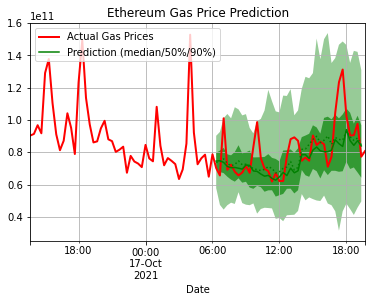

In [9]:
image = "pred_{}_{}_{}_{}.jpg".format(target_date, DELTA, AGG, len(features))
real_pre = to_pandas(test_entry)
start = real_pre.index[-50]
end = start + timedelta(minutes=(50 + DELTA)*AGG)
valid_ds = deep_ds[start:end]
valid_ds.plot(linewidth=2, color='r', label='Actual Gas Prices')
forecast.plot(color='g', prediction_intervals=[50.0, 90.0], show_mean=True, label='Predicted')
plt.grid(which='both')
plt.title('Ethereum Gas Price Prediction')
plt.legend(["Actual Gas Prices", "Prediction (median/50%/90%)"], loc="upper left")
plt.savefig(image, dpi=150, bbox_inches='tight')
plt.show()

In [10]:
start = target_date + timedelta(minutes=AGG)
end = target_date + timedelta(minutes=AGG*DELTA)
real = deep_ds[start:end]['Price']
sc = MinMaxScaler(feature_range=(0,1))
real=real.values.reshape(-1, 1)
pred=pred.values.reshape(-1, 1)
real = sc.fit_transform(real)
pred = sc.transform(pred)

csv_file = "pred_{}_{}_{}_{}.csv".format(target_date, DELTA, AGG, len(features))
with open(csv_file, 'w') as writer:
    writer.write("MAE,{}\n".format(mean_absolute_error(real, pred)))
    writer.write("MSE,{}\n".format(mean_squared_error(real, pred)))
    writer.write("R2,{}\n".format(r2_score(real, pred)))
    writer.write("RMSE,{}\n".format(sqrt(mean_squared_error(real, pred))))

In [11]:

print('Last run:', image, csv_file)

Last run: pred_2021-10-17 06:00:00_40_20_6.jpg pred_2021-10-17 06:00:00_40_20_6.csv
